# PE Segmentation Pipeline

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.1.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.2
Nibabel version: 5.3.2
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.16.1+cu118
tqdm version: 4.66.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import psutil

print(f"💻 Total system memory: {psutil.virtual_memory().total / (1024**3):.1f} GB")

💻 Total system memory: 1510.6 GB


## Experiment Logging on wandb

In [29]:
import wandb

# === Experiment name ===
exp_name = "CADPE-exp4"
run_save_dir = "./"+exp_name
os.makedirs(run_save_dir, exist_ok=True)

# === Core Settings ===
epochs = 400
lr = 1e-4
batch_size = 4
loss_func = "DiceFocalLoss"  # <- use "DiceFocalLoss" if you switch
model = "3D UNet"
modality = "CT"
patch_size = (128, 128, 96)
patch_num_samples = 6
window_center = 100
window_width = 700
pos_neg_ratio = (2, 1)  # pos=2, neg=1
cache_rate = 1
allow_smaller = True
image_threshold = -1200
image_visual_epochs = 10
scheduler = "ReduceLROnPlateau"
val_interval = 1

# === Dataset Count, will be updated later when loading the split
data_split_folder = "../cadpe_data/split.json"
train_cnt, val_cnt, test_cnt = 0, 0, 0

# === Model Arch ===
channels = (16, 32, 64, 128)
strides = (2, 2, 2)
in_channels = 1
out_channels = 2

# External Validation
external_split_folder = "../fumpe_data/split.json"

# === WandB Init ===
run = wandb.init(
    project="PE-Seg",
    name=exp_name,
    config={
        # Optimization
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "metric": "Dice",
        "scheduler": scheduler,

        # Data/Transform
        "window_center": window_center,
        "window_width": window_width,
        "patch_size": patch_size,
        "patch_num_samples": patch_num_samples,
        "patch_pos_neg_ratio": pos_neg_ratio,
        "cache_rate": cache_rate,
        "allow_smaller": allow_smaller,
        "image_threshold": image_threshold,

        # Model
        "model": model,
        "modality": modality,
        "model_in_channels": in_channels,
        "model_out_channels": out_channels,
        "model_channels": channels,
        "model_strides": strides,

        # Dataset counts
        "data_split": data_split_folder,
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
        
        # External validation split
        "external_val_split": external_split_folder
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)


external_test/dice,▁
external_test/loss,▁
test/dice,▁
test/loss,▁
train/loss,█▆▅▄▃▂▂▁
train/lr,▁▁▁▁▁▁▁▁
val/dice,▁▁▁▁▃▃█
val/loss,█▆▄▃▃▃▁
external_test/dice,0.11794
external_test/loss,0.55279
test/dice,0.09013


## Train-Val-Test Split

In [30]:
import json

# Path to your saved split file
split_json_path = data_split_folder

# Load split dictionary
with open(split_json_path, "r") as f:
    split = json.load(f)

# Access splits
train_files = split["train"]
val_files = split["val"]
test_files = split["test"]

print(f"✅ Loaded split from {split_json_path}")
print(f"📊 Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# === Update WandB config dynamically
wandb.config.update({
    "train_cnt": len(train_files),
    "val_cnt": len(val_files),
    "test_cnt": len(test_files)
})

✅ Loaded split from ../cadpe_data/split.json
📊 Train: 65 | Val: 13 | Test: 13


In [31]:
set_determinism(seed=0)

## Define Transform

In [32]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Orientationd,
    Spacingd, RandCropByPosNegLabeld, SpatialPadd, LambdaD
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=window_center-window_width/2, a_max=window_center+window_width/2,     
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        
        # 🔧 Pad to minimum size required for cropping
        SpatialPadd(keys=["image", "label"], spatial_size=patch_size),
        
        # Convert Instance Segmentation to Binary Segmentation mask
        LambdaD(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
        
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,  # Smaller patch focuses better
            pos=pos_neg_ratio[0],                      # More positives
            neg=pos_neg_ratio[1],
            num_samples=patch_num_samples,             # More tries per volume
            image_key="image",
            image_threshold=image_threshold,
            allow_smaller=allow_smaller
        ),
    ]
)

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=window_center-window_width/2, a_max=window_center+window_width/2,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    # 🔧 Pad to minimum size required for cropping
    SpatialPadd(keys=["image", "label"], spatial_size=patch_size),
    # Convert Instance Segmentation to Binary Segmentation mask
    LambdaD(keys=["label"], func=lambda x: (x > 0).astype(x.dtype)),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
    # optionally pad if needed (some validation images might be small after spacing)
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 64)),
])

### Visualizing an Example

image shape: torch.Size([512, 512, 96]), label shape: torch.Size([512, 512, 96])
Label unique values: metatensor([0., 1.])
🧠 Non-zero label found at slice 20 with area 45.0
🧠 Non-zero label found at slice 21 with area 42.0
🧠 Non-zero label found at slice 27 with area 53.0
🧠 Non-zero label found at slice 28 with area 49.0
🧠 Non-zero label found at slice 30 with area 43.0
🧠 Non-zero label found at slice 31 with area 57.0
🧠 Non-zero label found at slice 32 with area 60.0
🧠 Non-zero label found at slice 33 with area 100.0
🧠 Non-zero label found at slice 34 with area 97.0
🧠 Non-zero label found at slice 35 with area 81.0
🧠 Non-zero label found at slice 36 with area 82.0
🧠 Non-zero label found at slice 37 with area 72.0
🧠 Non-zero label found at slice 38 with area 104.0
🧠 Non-zero label found at slice 39 with area 106.0
🧠 Non-zero label found at slice 40 with area 103.0
🧠 Non-zero label found at slice 41 with area 204.0
🧠 Non-zero label found at slice 42 with area 167.0
🧠 Non-zero label foun

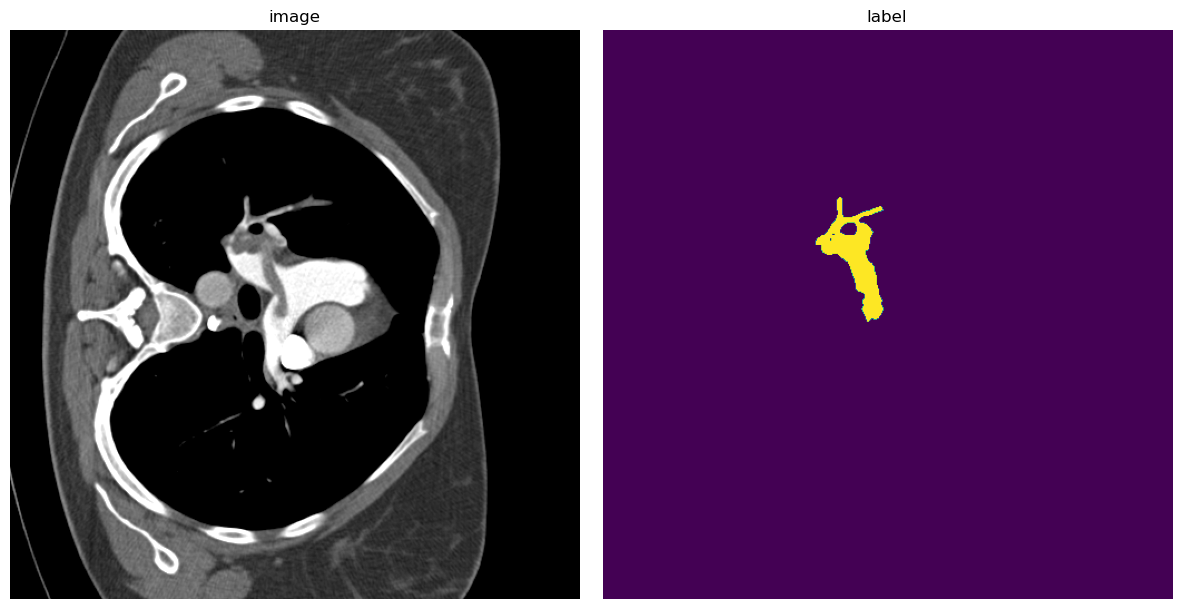

In [33]:
import matplotlib.pyplot as plt

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print("Label unique values:", torch.unique(label))

# Find the first slice where label is non-zero
max_idx = None
non_empty = []
max_area = -1
for i in range(label.shape[-1]):
    pos_cnt = label[..., i].sum()
    if pos_cnt > 0:
        if pos_cnt > max_area:
            max_idx = i
            max_area = pos_cnt
        print(f"🧠 Non-zero label found at slice {i} with area {label[..., i].sum()}")
        non_empty.append(i)

print(non_empty)

# If found, visualize
if max_idx is not None:
    plt.figure("check", figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, max_idx], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, max_idx])
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No non-zero label slice found.")


## Create Cached Dataset to accelerate

In [34]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate, num_workers=2)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

test_ds = CacheDataset(data=test_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 13/13 [01:13<00:00,  5.68s/it]


### Examine a Batch (and its patches) Balance

In [35]:
from monai.utils import first
import numpy as np

sample = first(train_loader)

print("📦 Batch shape:", sample["image"].shape)  # (B, C, H, W, D)

for i in range(sample["label"].shape[0]):
    label_patch = sample["label"][i][0]  # [0] = squeeze channel
    pe_voxels = label_patch.sum().item()
    print(f"🧠 Patch {i}: PE voxels = {pe_voxels}")

📦 Batch shape: torch.Size([12, 1, 128, 128, 96])
🧠 Patch 0: PE voxels = 1571.0
🧠 Patch 1: PE voxels = 1571.0
🧠 Patch 2: PE voxels = 0.0
🧠 Patch 3: PE voxels = 1571.0
🧠 Patch 4: PE voxels = 0.0
🧠 Patch 5: PE voxels = 1571.0
🧠 Patch 6: PE voxels = 72616.0
🧠 Patch 7: PE voxels = 58104.0
🧠 Patch 8: PE voxels = 0.0
🧠 Patch 9: PE voxels = 14026.0
🧠 Patch 10: PE voxels = 58653.0
🧠 Patch 11: PE voxels = 11617.0


In [36]:
def save_checkpoint():
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "epoch": epoch,
        "offset": offset,
        "best_metric": best_metric,
        "best_metric_epoch": best_metric_epoch
    }, os.path.join(run_save_dir, "checkpoint.pth"))

## Define Model, Loss, Optimizer and Scheduler

In [37]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# 🔁 Switched loss to DiceFocalLoss
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",         # Since lower loss is better
    factor=0.9,         # Halve LR if no improvement
    patience=20,        # Wait 10 epochs
    verbose=True,
    min_lr=1e-5         # Don’t go below this
)

In [39]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")

## Train-Val Loop

In [ ]:
# Optional: Load checkpoint
resume = os.path.exists(os.path.join(run_save_dir, "checkpoint.pth"))
if resume:
    checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"]) 
    start_epoch = checkpoint["epoch"] + 1
    best_metric = checkpoint["best_metric"]
    best_metric_epoch = checkpoint["best_metric_epoch"]
    print(f"[🔄] Resuming from epoch {start_epoch}, best metric {best_metric:.4f}")
else:
    start_epoch = 0
    offset = 0
    best_metric = -1
    best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
epoch_range = trange(start_epoch, start_epoch + epochs, desc="Training Epochs")

# --- Training Loop ---
for epoch in epoch_range:
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss, "train/lr": optimizer.param_groups[0]["lr"]}, step=epoch)

    # --- Validation ---
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()
                val_steps += 1

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

        val_loss /= val_steps
        metric = dice_metric.aggregate().item()
        dice_metric.reset()

        metric_values.append(metric)
        wandb.log({"val/dice": metric, "val/loss": val_loss}, step=epoch)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            save_checkpoint()
            print("[💾] Saved new best metric model")

        if epoch % image_visual_epochs == 0:
            val_image = val_data["image"][0, 0].detach().cpu().numpy()
            val_label = val_data["label"][0, 0].detach().cpu().numpy()
            val_pred = torch.argmax(val_outputs[0], dim=0).detach().cpu().numpy()
            mid_slice = val_image.shape[2] // 2
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
            axs[0].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[0].set_title("Input")
            axs[1].imshow(val_image[:, :, mid_slice], cmap="gray")
            axs[1].imshow(val_pred[:, :, mid_slice], cmap="Reds", alpha=0.4)
            axs[1].set_title("Prediction on Input")
            axs[2].imshow(val_pred[:, :, mid_slice])
            axs[2].set_title("Prediction")
            axs[3].imshow(val_label[:, :, mid_slice])
            axs[3].set_title("Ground Truth")
            plt.tight_layout()
            wandb.log({"val/visual": wandb.Image(fig)}, step=epoch)
            plt.close(fig)
        scheduler.step(val_loss)


Training Epochs:   0%|          | 0/400 [02:01<?, ?it/s, loss=0.766]

[💾] Saved new best metric model


Training Epochs:   1%|          | 3/400 [08:29<18:34:31, 168.44s/it, loss=0.681]

[💾] Saved new best metric model


Training Epochs:   1%|          | 4/400 [11:11<18:15:17, 165.95s/it, loss=0.661]

[💾] Saved new best metric model


Training Epochs:   1%|▏         | 5/400 [13:56<18:09:52, 165.55s/it, loss=0.641]

[💾] Saved new best metric model


Training Epochs:   2%|▏         | 6/400 [16:42<18:07:11, 165.56s/it, loss=0.624]

[💾] Saved new best metric model


Training Epochs:   2%|▏         | 7/400 [19:21<17:49:58, 163.35s/it, loss=0.606]

[💾] Saved new best metric model


## Plot a few Validation performance

In [ ]:
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 80
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 10:
            break

## Evaluate Generate Prediction Masks for Test
Note we need to rotate 90 degress and flip along X axis

In [ ]:
import os
import torch
import nibabel as nib
import numpy as np
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import Compose, AsDiscrete
from monai.data import decollate_batch

# === Post-processing and loss ===
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean")
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# === Load model ===
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

output_base_dir = os.path.join(run_save_dir, "predictions")
os.makedirs(output_base_dir, exist_ok=True)

test_loss_total = 0.0
test_case_count = 0

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="🧪 Test Inference", unit="case")):
        image = batch["image"].to(device)
        label = batch["label"].to(device)
        image_path = test_loader.dataset.data[i]["image"]
        affine = nib.load(image_path).affine

        # Predict
        test_outputs = sliding_window_inference(image, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model)

        # Compute loss
        loss = loss_function(test_outputs, label)
        test_loss_total += loss.item()
        test_case_count += 1

        # Post-process for metric
        outputs_post = [post_pred(i) for i in decollate_batch(test_outputs)]
        labels_post = [post_label(i) for i in decollate_batch(label)]
        dice_metric(y_pred=outputs_post, y=labels_post)

        # Convert prediction for saving
        pred = torch.argmax(test_outputs, dim=1).cpu().numpy()[0]
        pred = np.flip(pred, axis=0)
        pred = np.flip(pred, axis=1)

        print(f"[DEBUG] pred shape: {pred.shape}, unique values: {np.unique(pred)}")

        # Save
        patient_id = os.path.basename(os.path.dirname(image_path))
        os.makedirs(os.path.join(output_base_dir, patient_id), exist_ok=True)
        filename = os.path.basename(image_path).replace(".nii.gz", "_pred.nii.gz")
        save_path = os.path.join(output_base_dir, patient_id, filename)
        nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), save_path)
        print(f"✅ Saved: {save_path}")

# === Aggregate and log test metrics ===
mean_test_dice = dice_metric.aggregate().item()
mean_test_loss = test_loss_total / test_case_count
dice_metric.reset()

print(f"📊 Test Dice: {mean_test_dice:.4f}")
print(f"📉 Test Loss: {mean_test_loss:.4f}")

# === WandB log ===
wandb.log({
    "test/dice": mean_test_dice,
    "test/loss": mean_test_loss
})


## Validate CAD-PE model on external validation set (FUMPE)

In [ ]:
import glob
import os

# Path to your saved split file
split_json_path = external_split_folder

# Load split dictionary
with open(split_json_path, "r") as f:
    external_split = json.load(f)

# Access splits
external_test_files = external_split["test"]

print(f"✅ Total cases: {len(external_test_files)}")

In [ ]:
external_test_ds = CacheDataset(data=external_test_files, transform=val_transforms, cache_rate=cache_rate, num_workers=2)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=2)

In [ ]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    strides=strides,
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
# Load model
checkpoint = torch.load(os.path.join(run_save_dir, "checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete, Compose
from monai.data import decollate_batch

# Match your post transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Match your loss function and metric
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

external_test_loss = 0.0
val_steps = 0

model.eval()
with torch.no_grad():
    for val_data in external_test_loader:
        val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

        # Inference
        val_outputs = sliding_window_inference(
            val_inputs, roi_size=(160, 160, 160), sw_batch_size=4, predictor=model
        )

        # Loss (raw output vs. label)
        loss = loss_function(val_outputs, val_labels)
        external_test_loss += loss.item()
        val_steps += 1

        # Post-processing for Dice
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred=val_outputs, y=val_labels)

# Aggregated metrics
external_test_loss /= val_steps
val_dice = dice_metric.aggregate().item()
dice_metric.reset()

print(f"📊 External Validation Dice: {val_dice:.4f}")
print(f"📉 External Validation Loss: {external_test_loss:.4f}")

# === WandB log ===
wandb.log({
    "external_test/dice": val_dice,
    "external_test/loss": external_test_loss
})